# C8.2
Jeg Vet

huangzw29@mail2.sysu.edu.cn

2022-05-18

In [52]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sympy as sp
import glob,os
from scipy.signal import argrelextrema

In [53]:
model = "Model2"

## Load data

In [54]:
def getallfile(path, extension):
    filepathdic = {}
    for root, dirs, files in os.walk(path):
        for file in files:
            if extension in file:
                filepath = root + "/" + file
                filepathdic[file]= filepath
    return filepathdic

In [55]:
dfdic = {}
path = "Input/" +model+"/"
for fname, fpath in getallfile(path, ".tsv").items():
    dfdic[fname.rstrip(".tsv")] = pd.read_csv(fpath, sep="\s+")
print(dfdic.keys())

dict_keys(['0.020', '0.025', '0.030', '0.035', '0.040'])


In [56]:
dfdic["Par"] = pd.read_csv("Input/Par.csv")

## Temperature-Time

In [57]:
def smoothplot(df, par, dense=50, s=1, method="Rbf", scatter=False, 
               xlab="x", ylab="y", result_path="Output/smooth.png"):
    '''
    df: dataframe
    par: {"x": "", "y1": "", "y2": "", ...}
    s: smooth degree
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.interpolate import UnivariateSpline,Rbf
    import re
    from scipy.signal import argrelextrema
    # smooth
    x_dense = np.linspace(df[par["x"]].min(), df[par["x"]].max(), dense)
    ylist = list(filter(lambda y: re.match('y.*', y) != None, par.keys()))
    if method == "Rbf":
        for y in ylist:
            smoothfunc = Rbf(df[par["x"]], df[par[y]], s=s)
            globals()[y+"_smooth"] = smoothfunc(x_dense)
    elif method == "Rbf":
        for y in ylist:
            smoothfunc = UnivariateSpline(df[par["x"]], df[par[y]], s=s)
            globals()[y+"_smooth"] = smoothfunc(x_dense)
    
    # Plot
    plt.figure(figsize= (10, 6))
    ## lab
    if xlab == "x":
        xlab = par["x"]
    if ylab == "y":
        ylab = par["y"]
    ## Scatter
    if scatter == True:
        for i in np.arange(0, len(ylist), 1):
            x = np.array(df[par["x"]])
            y = np.array(df[par[ylist[i]]])
            # plt.scatter(x, y, color=plt.cm.Set2(i), alpha=0.5, s=10)
            ## Add line:
            top_loc = np.argmax(y)
            # plt.vlines(x[top_loc], 0.1, y[top_loc], ls=':', color = plt.cm.Set2(i))
            plt.hlines(y[top_loc], 0, x[top_loc], ls=':', color = plt.cm.Set2(i))
            # plt.annotate('{:.2f}'.format(y[top_loc]), xy=(300, y[top_loc]+0.22), color=plt.cm.Set2(i)) # For model1
            plt.annotate('({:.2f}, {:.2f})'.format(x[top_loc], y[top_loc]), xy=(x[top_loc]-150, y[top_loc]+0.22), color=plt.cm.Set2(i)) # For model2

    ## Smooth
    for i in np.arange(0, len(ylist), 1):
        x = x_dense
        y = eval(ylist[i]+"_smooth")
        plt.plot(x, y, color=plt.cm.Set2(i), label=par[ylist[i]])                          
    ## Lab
    plt.legend()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    # plt.title(y=-0.17)
    plt.savefig(result_path, bbox_inches = 'tight', dpi=300) 

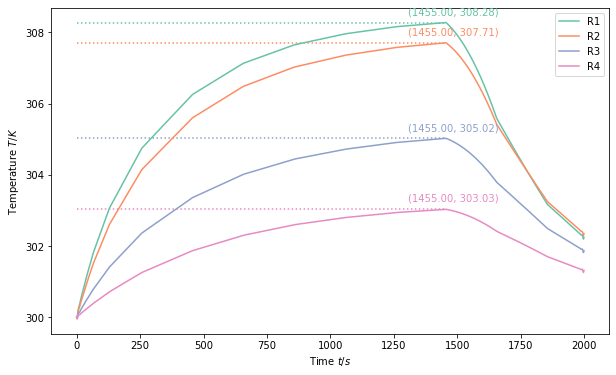

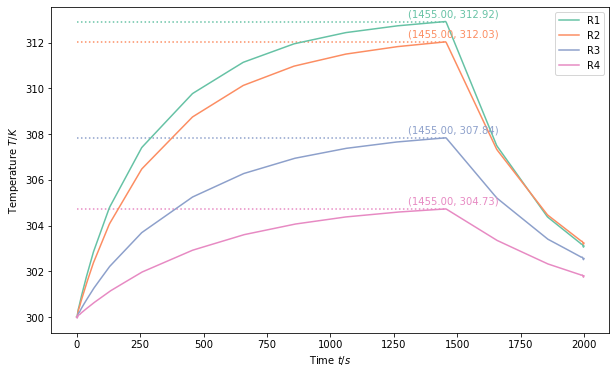

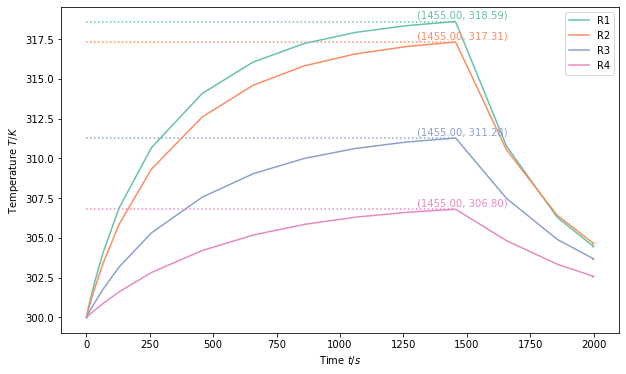

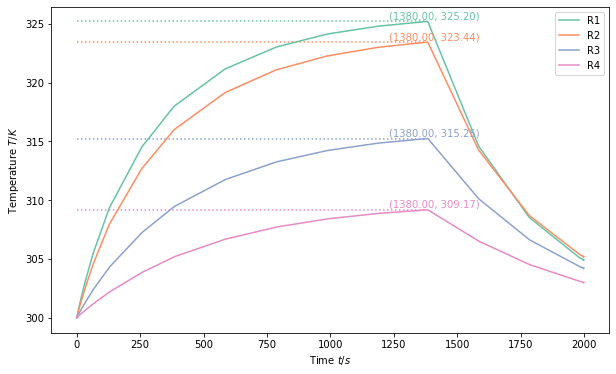

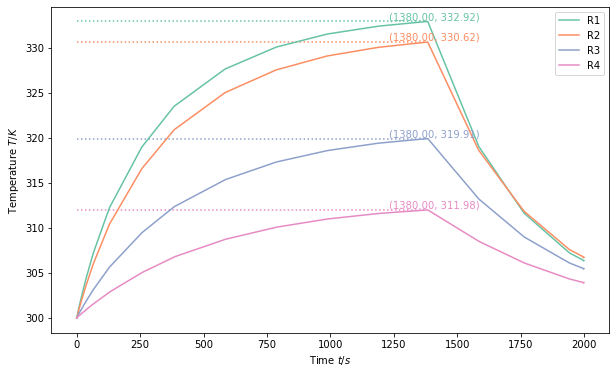

In [58]:
I = ['0.020', '0.025', '0.030', '0.035', '0.040']
for dfid in I:
    df = dfdic[dfid].copy(deep=True)
    smoothplot(df, {"x": "t", "y1": "R1", "y2": "R2","y3": "R3", "y4": "R4"}, 
            dense=1000, s=1000, method="Rbf", scatter=True,
            xlab="Time $t/s$", ylab="Temperature $T /K$", result_path="Output/"+model+"/Temperature-Time/"+dfid+".png")

## Temperature-Power

In [59]:
def fitplot(df, par, xlab="x", ylab="y", deg=1, result_path="Output/fit.png", label="Data"):
    '''
    df: dataframe
    par: {"x": "", "y": ""}
    deg: fit degree
    '''
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np
    # fit
    func = np.polyfit(df[par["x"]], df[par["y"]], deg=deg)
    x_dense = np.linspace(df[par["x"]].min(), df[par["x"]].max(), 50)
    reg = np.polyval(func, x_dense)
    r = np.corrcoef(df[par["x"]], df[par["y"]])[0,1]
    coef_1, coef_2 = tuple(func)
    plt.figure(figsize= (10, 6))
    plt.scatter(df[par["x"]], df[par["y"]], color='lightcoral', label=label)
    plt.plot(x_dense, reg, color='lightseagreen', 
                            label='Fit. \ny = {:.4f}x + {:.4f}\nr = {:.8f}'
                            .format(coef_1, coef_2, r))    
    sns.regplot(x=df[par["x"]], y=df[par["y"]], color = 'lightseagreen', scatter = False)                          
    plt.legend()
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    # plt.title(y=-0.17)
    plt.savefig(result_path, bbox_inches = 'tight', dpi=300)   

In [60]:
I = ['0.020', '0.025', '0.030', '0.035', '0.040']
df_par = dfdic["Par"].copy(deep=True)
df_par.index = I
for dfid in I:
    df = dfdic[dfid]
    for rid in np.arange(1,5,1):
        rid = str(rid)
        df_par["P"+rid] = (df_par["I"])**2*df_par["R"+rid] # Calculate power for this resistance
        temp = np.array(df["R"+rid]) # Temperature of this resistance
        df_par.loc[dfid, "Tmax"+rid] = temp[np.argmax(temp)]
df_par
df_par.to_csv("Output/"+model+"/Par.csv")

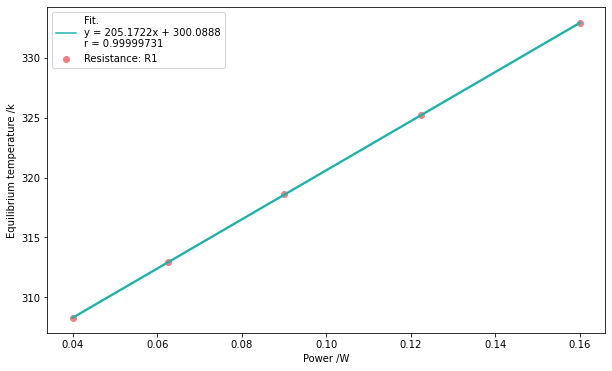

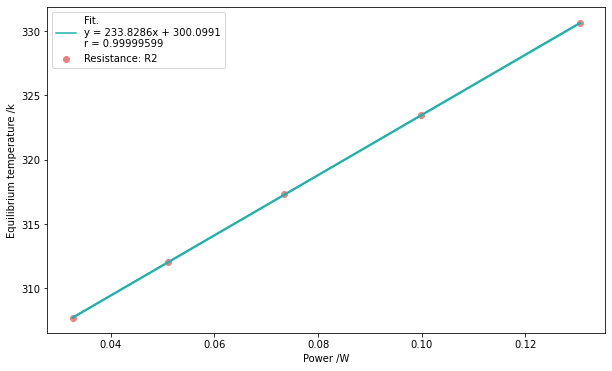

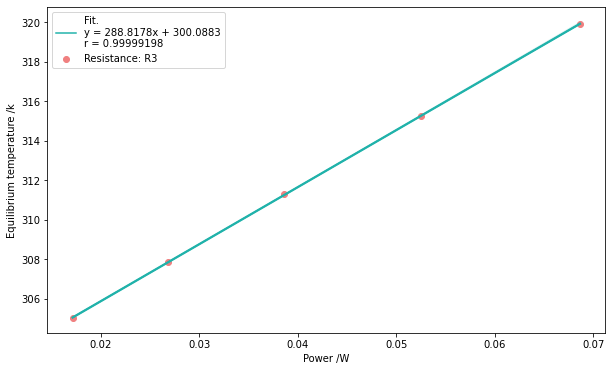

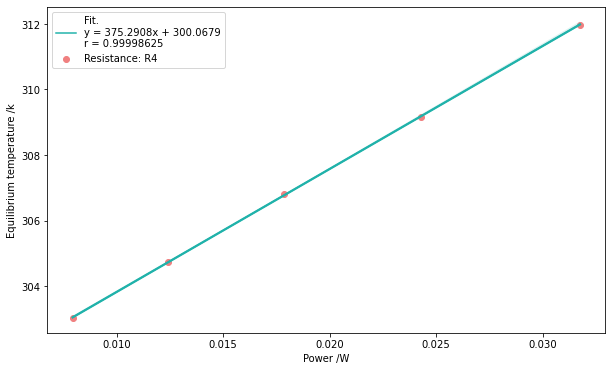

In [61]:
for rid in np.arange(1,5,1):
    rid = str(rid)
    fitplot(df_par, par={"x": "P"+rid, "y": "Tmax"+rid}, deg=1, 
            xlab="Power /W", ylab="Equilibrium temperature /k", 
            label="Resistance: R"+rid,
            result_path="Output/"+model+"/Temperature-Power/R"+rid+".png")